# Mean-Variance Optimization

MPT solves for the optimal portfolio weights to minimize volatility for a given expected return, or maximize returns for a given level of volatility. The key requisite input are expected asset returns, standard deviations, and the covariance matrix. 

Diversification works because the variance of portfolio returns depends on the covariance of the assets and can be reduced below the weighted average of the asset variances by including assets with less than perfect correlation. In particular, given a vector, ω, of portfolio weights and the covariance matrix, $\Sigma$, the portfolio variance, $\sigma_{\text{PF}}$ is defined as:
$$\sigma_{\text{PF}}=\omega^T\Sigma\omega$$

Markowitz showed that the problem of maximizing the expected portfolio return subject to a target risk has an equivalent dual representation of minimizing portfolio risk subject to a target expected return level, μPF. Hence, the optimization problem becomes:
$$
\begin{align}
\min_\omega & \quad\quad\sigma^2_{\text{PF}}= \omega^T\Sigma\omega\\
\text{s.t.} &\quad\quad \mu_{\text{PF}}= \omega^T\mu\\ 
&\quad\quad \lVert\omega\rVert =1
\end{align}
$$

We can calculate an efficient frontier using `scipy.optimize.minimize` and the historical estimates for asset returns, standard deviations, and the covariance matrix. 

## Imports & Settings

In [273]:
import warnings

import pandas as pd  
import numpy as np
from numpy.random import random, uniform, normal, dirichlet, choice
from numpy.linalg import inv

from scipy.optimize import minimize

import pandas_datareader.data as web
from itertools import repeat, product
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use('fivethirtyeight')
np.random.seed(42)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.filterwarnings('ignore')

In [3]:
cmap = sns.diverging_palette(10, 240, n=9, as_cmap=True)

## Prepare Data

We select historical data for tickers included in the S&P500 (according to Wikipedia) from 1998-2017.

In [267]:
with pd.HDFStore('../../data/assets.h5') as store:
    sp500_stocks = store['sp500/stocks'].index 
    prices = store['quandl/wiki/prices'].adj_close.unstack('ticker').filter(sp500_stocks).sample(n=50, axis=1)

## Compute Inputs

### Compute Returns

In [268]:
start = 1988
end = 2017

Create month-end monthly returns and drop dates that have no observations:

In [269]:
monthly_returns = prices.loc[f'{start}':f'{end}'].resample('M').last().pct_change().dropna(how='all')
monthly_returns = monthly_returns.dropna(axis=1)
monthly_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 359 entries, 1988-02-29 to 2017-12-31
Freq: M
Data columns (total 25 columns):
ADP     359 non-null float64
HPQ     359 non-null float64
NEM     359 non-null float64
ROST    359 non-null float64
BAX     359 non-null float64
WHR     359 non-null float64
HAS     359 non-null float64
INTC    359 non-null float64
ADI     359 non-null float64
CVX     359 non-null float64
TMO     359 non-null float64
SNA     359 non-null float64
NOC     359 non-null float64
BMY     359 non-null float64
WY      359 non-null float64
ARNC    359 non-null float64
PVH     359 non-null float64
PEP     359 non-null float64
AME     359 non-null float64
FL      359 non-null float64
CSX     359 non-null float64
T       359 non-null float64
BAC     359 non-null float64
WBA     359 non-null float64
ES      359 non-null float64
dtypes: float64(25)
memory usage: 72.9 KB


### Set  Parameters

In [270]:
stocks = monthly_returns.columns

In [271]:
n_obs, n_assets = monthly_returns.shape
n_assets, n_obs

(25, 359)

In [239]:
NUM_PF = 100000 # no of portfolios to simulate

In [240]:
x0 = uniform(-1, 1, n_assets)
x0 /= np.sum(np.abs(x0))

### Annualization Factor

In [241]:
periods_per_year = round(monthly_returns.resample('A').size().mean())
periods_per_year

12

### Compute Covariance

In [12]:
mean_returns = monthly_returns.mean()
cov_matrix = monthly_returns.cov()
precision_matrix = pd.DataFrame(inv(cov_matrix), index=stocks, columns=stocks)

In [13]:
treasury_10yr_monthly = (web.DataReader('DGS10', 'fred', start, end)
                         .resample('M')
                         .last()
                         .div(periods_per_year)
                         .div(100)
                         .squeeze())

### Risk-Free Rate

In [14]:
rf_rate = treasury_10yr_monthly.mean()

In [16]:
alpha = np.full(shape=n_assets, fill_value=.01)
weights = dirichlet(alpha=alpha, size=NUM_PF)
weights *= choice([-1, 1], size=weights.shape)
weights.shape

(100000, 217)

## Simulate Random Portfolios

The simulation generates random weights using the Dirichlet distribution, and computes the mean, standard deviation, and SR for each sample portfolio using the historical return data:

In [258]:
def simulate_portfolios(mean_ret, cov, rf_rate=rf_rate, short=True):
    alpha = np.full(shape=n_assets, fill_value=.025)
    weights = dirichlet(alpha=alpha, size=NUM_PF)
    weights *= choice([-1, 1], size=weights.shape)

    returns = weights @ mean_ret.values + 1
    returns = returns ** periods_per_year - 1
    std = (weights @ monthly_returns.T).std(1)
    std *= np.sqrt(periods_per_year)
    sharpe = (returns - rf_rate) / std

    return pd.DataFrame({'Annualized Standard Deviation': std,
                         'Annualized Returns': returns,
                         'Sharpe Ratio': sharpe}), weights

In [259]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=False)

### Plot Simulated Portfolios

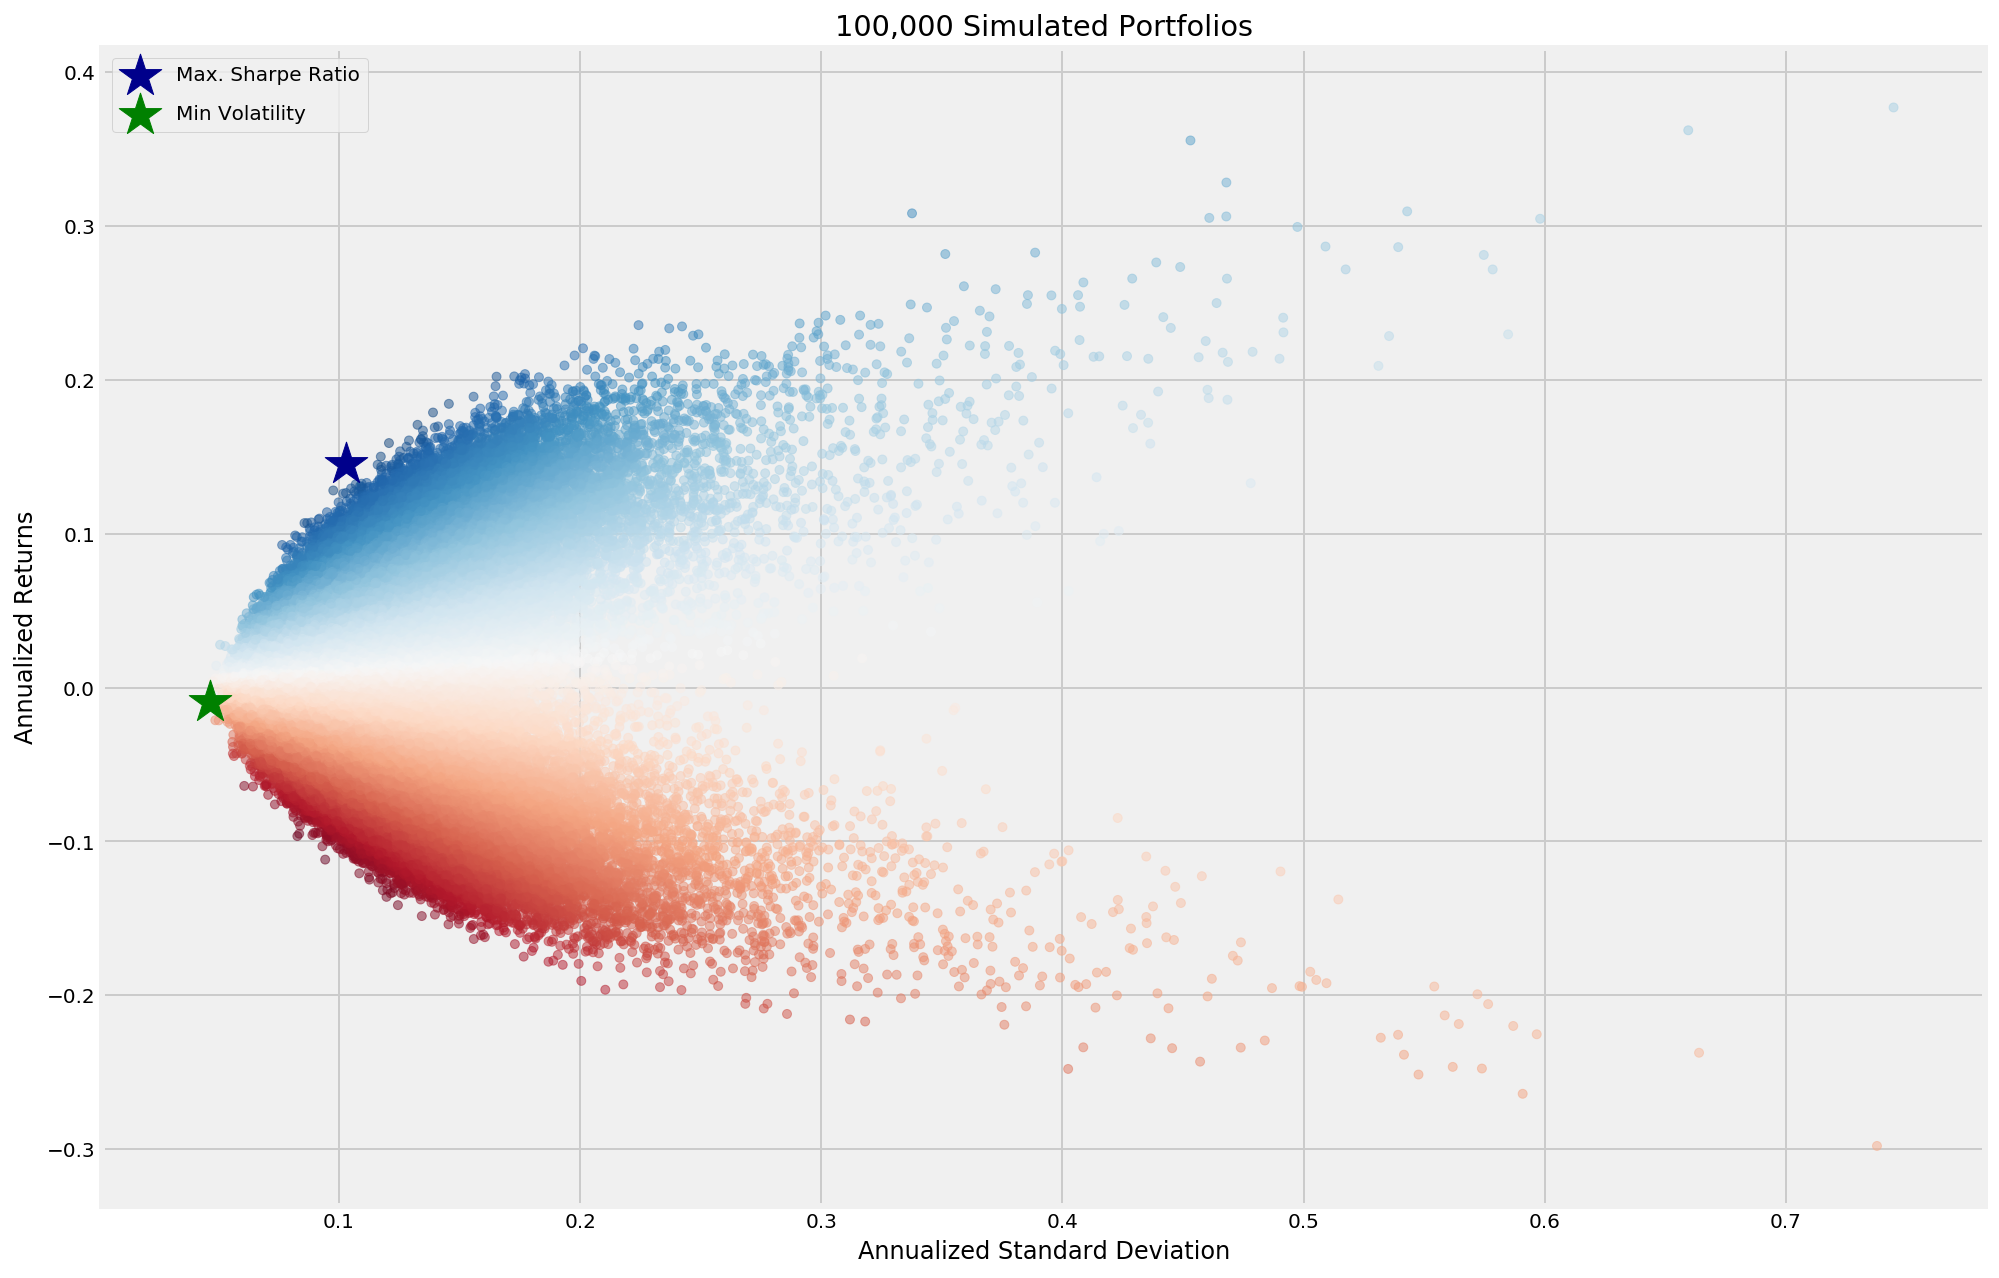

In [60]:
# pandas 0.24 will fix bug with colorbars: https://github.com/pandas-dev/pandas/pull/20446
ax = simul_perf.plot.scatter(x=0, y=1, c=2,
                             cmap='RdBu',
                             alpha=0.5, figsize=(14, 9), colorbar=False,
                             title=f'{NUM_PF:,d} Simulated Portfolios')

max_sharpe_idx = simul_perf.iloc[:, 2].idxmax()
sd, r = simul_perf.iloc[max_sharpe_idx, :2].values
ax.scatter(sd, r, marker='*', color='darkblue',
           s=500, label='Max. Sharpe Ratio')

min_vol_idx = simul_perf.iloc[:, 0].idxmin()
sd, r = simul_perf.iloc[min_vol_idx, :2].values
ax.scatter(sd, r, marker='*', color='green', s=500, label='Min Volatility')
plt.legend(labelspacing=1, loc='upper left')
plt.tight_layout()

## Compute Annualize PF Performance

Set up the quadratic optimization problem to solve for the minimum standard deviation for a given return or the maximum SR. 

To this end, define the functions that measure the key metrics:

In [61]:
def portfolio_std(wt, rt=None, cov=None):
    """Annualized PF standard deviation"""
    return np.sqrt(wt @ cov @ wt * periods_per_year)

In [62]:
def portfolio_returns(wt, rt=None, cov=None):
    """Annualized PF returns"""
    return (wt @ rt + 1) ** periods_per_year - 1

In [63]:
def portfolio_performance(wt, rt, cov):
    """Annualized PF returns & standard deviation"""
    r = portfolio_returns(wt, rt=rt)
    sd = portfolio_std(wt, cov=cov)
    return r, sd

## Max Sharpe PF

Define a target function that represents the negative SR for scipy's minimize function to optimize given the constraints that the weights are bounded by, [-1, 1], and sum to one in absolute terms

In [64]:
def neg_sharpe_ratio(weights, mean_ret, cov):
    r, sd = portfolio_performance(weights, mean_ret, cov)
    return -(r - rf_rate) / sd

In [65]:
weight_constraint = {'type': 'eq', 
                     'fun': lambda x: np.sum(np.abs(x)) - 1}

In [66]:
def max_sharpe_ratio(mean_ret, cov, short=True):
    return minimize(fun=neg_sharpe_ratio,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=((-1 if short else 0, 1),) * n_assets,
                    constraints=weight_constraint,
                    options={'tol':1e-10, 'maxiter':1e4})

## Compute Efficient Frontier

The solution requires iterating over ranges of acceptable values to identify optimal risk-return combinations

In [68]:
def min_vol_target(mean_ret, cov, target, short=True):

    def ret_(wt):
        return portfolio_returns(wt, mean_ret)

    constraints = [{'type': 'eq', 'fun': lambda x: ret_(x) - target},
                   weight_constraint]

    bounds = ((-1 if short else 0, 1),) * n_assets
    return minimize(portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=constraints,
                    options={'tol': 1e-10, 'maxiter': 1e4})

The mean-variance frontier relies on in-sample, backward-looking optimization. In practice, portfolio optimization requires forward-looking input. Expected returns are notoriously difficult to estimate accurately.

The covariance matrix can be estimated somewhat more reliably, which has given rise to several alternative approaches. However, covariance matrices with correlated assets pose computational challenges since the optimization problem requires inverting the matrix. The high condition number induces numerical instability, which in turn gives rise to Markovitz curse: the more diversification is required (by correlated investment opportunities), the more unreliable the weights produced by the algorithm. 

## Min Volatility Portfolio

In [67]:
def min_vol(mean_ret, cov, short=True):
    bounds = ((-1 if short else 0, 1),) * n_assets

    return minimize(fun=portfolio_std,
                    x0=x0,
                    args=(mean_ret, cov),
                    method='SLSQP',
                    bounds=bounds,
                    constraints=weight_constraint,
                    options={'tol': 1e-10, 'maxiter': 1e4})

In [69]:
def efficient_frontier(mean_ret, cov, ret_range, short=True):
    return [min_vol_target(mean_ret, cov, ret) for ret in ret_range]

## Run Calculation

### Get random PF

In [70]:
simul_perf, simul_wt = simulate_portfolios(mean_returns, cov_matrix, short=True)

In [71]:
print(simul_perf.describe())

       Annualized Standard Deviation  Annualized Returns  Sharpe Ratio
count                     100000.000          100000.000    100000.000
mean                           0.121               0.002        -0.022
std                            0.042               0.068         0.511
min                            0.048              -0.258        -1.214
25%                            0.093              -0.048        -0.466
50%                            0.112              -0.000        -0.043
75%                            0.139               0.050         0.413
max                            0.959               0.514         1.340


In [72]:
simul_max_sharpe = simul_perf.iloc[:, 2].idxmax()
simul_perf.iloc[simul_max_sharpe]

Annualized Standard Deviation   0.099
Annualized Returns              0.136
Sharpe Ratio                    1.340
Name: 86971, dtype: float64

### Get Max Sharpe PF

In [73]:
max_sharpe_pf = max_sharpe_ratio(mean_returns, cov_matrix, short=False)
max_sharpe_perf = portfolio_performance(max_sharpe_pf.x, mean_returns, cov_matrix)

In [74]:
r, sd = max_sharpe_perf
pd.Series({'ret': r, 'sd': sd, 'sr': (r-rf_rate)/sd})

ret   0.211
sd    0.108
sr    1.924
dtype: float64

From simulated pf data

### Get Min Vol PF

In [75]:
min_vol_pf = min_vol(mean_returns, cov_matrix, short=False)
min_vol_perf = portfolio_performance(min_vol_pf.x, mean_returns, cov_matrix)

### Get Efficent PFs

In [76]:
ret_range = np.linspace(0, simul_perf.iloc[:, 1].max() * 1.1, 25)
eff_pf = efficient_frontier(mean_returns, cov_matrix, ret_range,short=False)

### Plot Result

The simulation yields a subset of the feasible portfolios, and the efficient frontier identifies the optimal in-sample return-risk combinations that were achievable given historic data. 

The below figure shows the result including the minimum variance portfolio and the portfolio that maximizes the SR and several portfolios produce by alternative optimization strategies. The efficient frontier 

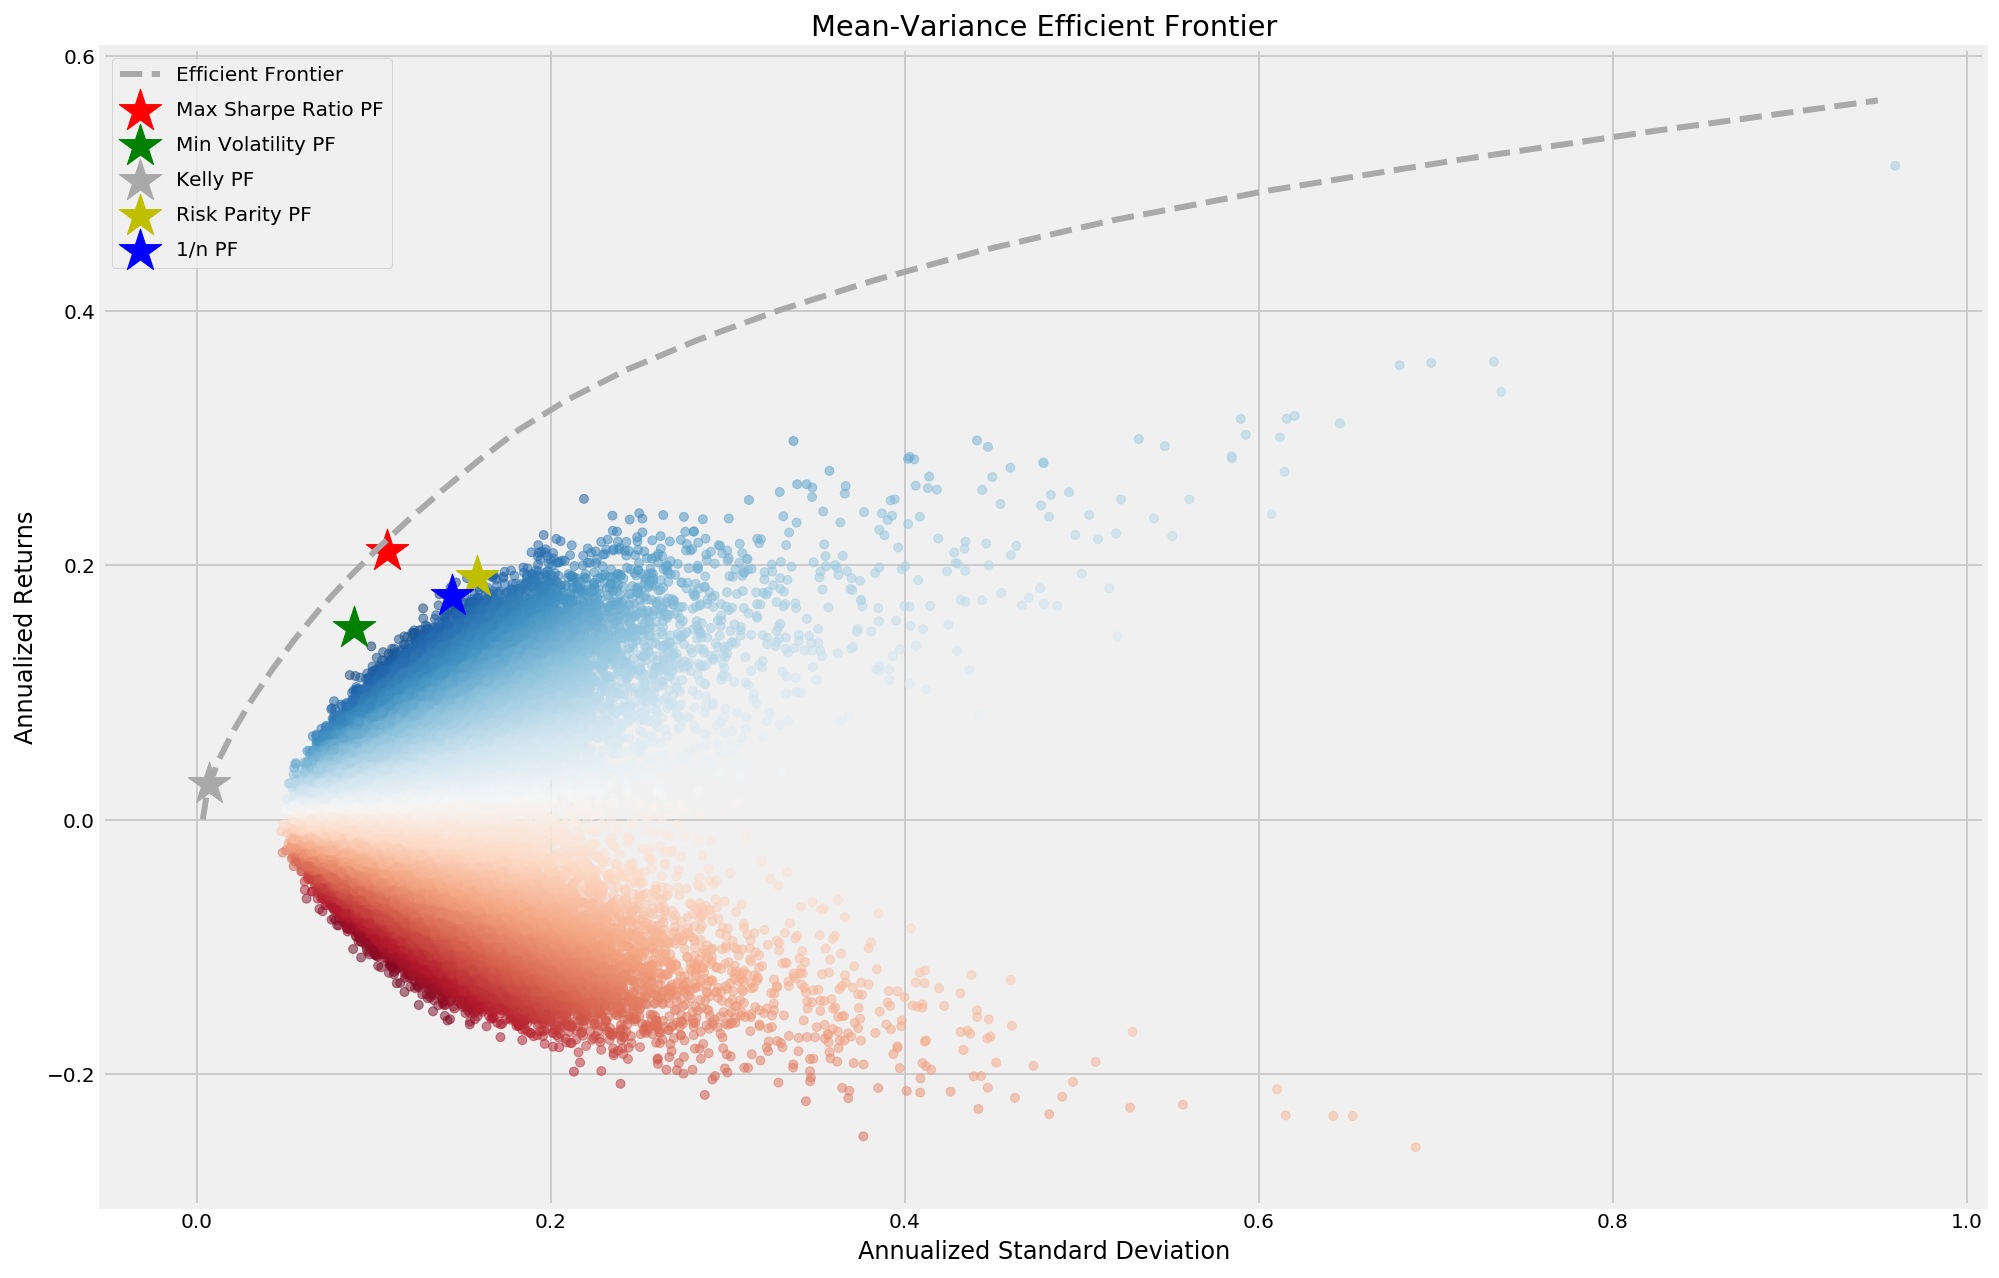

In [77]:
fig, ax = plt.subplots()
simul_perf.plot.scatter(x=0, y=1, c=2, ax=ax,
                                 cmap='RdBu',
                                 alpha=0.5, figsize=(14, 9), colorbar=False,
                                 title='Mean-Variance Efficient Frontier')

r, sd = max_sharpe_perf
ax.scatter(sd, r, marker='*', color='r', s=500, label='Max Sharpe Ratio PF')

r, sd = min_vol_perf
ax.scatter(sd, r, marker='*', color='g', s=500, label='Min Volatility PF')

kelly_wt = precision_matrix.dot(mean_returns).values
kelly_wt /= np.sum(np.abs(kelly_wt))
r, sd = portfolio_performance(kelly_wt, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='darkgrey', s=500, label='Kelly PF')

std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='y', s=500, label='Risk Parity PF')

r, sd = portfolio_performance(np.full(n_assets, 1/n_assets), mean_returns, cov_matrix)
ax.scatter(sd, r, marker='*', color='blue', s=500, label='1/n PF')

ax.plot([p['fun'] for p in eff_pf], ret_range, 
        linestyle='--', lw=3, color='darkgrey', label='Efficient Frontier')
ax.legend(labelspacing=0.8)
fig.tight_layout();

In [311]:
std = monthly_returns.std()
std /= std.sum()
r, sd = portfolio_performance(std, mean_returns, cov_matrix)
r, sd

(0.19091903997200999, 0.15813414921037125)